In [1]:
# EDA 사전 세팅
%matplotlib inline

import time
import os
os.environ['KMP_WARNINGS'] = 'off'
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
import seaborn as sns  #데이터 시각화 
sns.set(font="AppleGothic", 

        rc={"axes.unicode_minus":False},
        
        style='darkgrid')

# 모델링
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

In [3]:
train = pd.read_csv('/Users/choejeehyuk/분석에 필요한 데이터/신용커드 예측 경진대회/train.csv')
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


## 데이터 기본 정보

In [4]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

## 데이터 전처리

### 결측값 처리

In [6]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [7]:
data = train.fillna('Nan')

### 파생변수 생성

In [8]:
def make_derivation(data):
  data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else abs(x))

  feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
  for feat in feats:
    data[feat]=np.abs(data[feat])

  data = data[(data['family_size'] <= 7)]
  data = data.reset_index(drop=True)

  #data['DAYS_EMPLOYED'] = abs(data['DAYS_EMPLOYED'])
  #data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
  #data['begin_month'] = abs(data['begin_month'])
  
  data['new_age'] = round(abs(data['DAYS_BIRTH'])/365.5,0).astype(np.int)
  data['year_os'] = data['DAYS_EMPLOYED']//365 # 근속연수
  data['month_os'] = data['DAYS_EMPLOYED']//30 # 근속월수
  data['month_ap'] = np.floor(data['DAYS_EMPLOYED']/30) - ((np.floor(data['DAYS_EMPLOYED']/30) / 12).astype('int') * 12) # 고용된 달 
  data['week_ap'] = np.floor(data['DAYS_EMPLOYED']/7) - ((np.floor(data['DAYS_EMPLOYED']/7) / 4).astype('int') * 4) # 고용된 주
  data["bef_hire"] = data["DAYS_BIRTH"]-data["DAYS_EMPLOYED"]
  data['RATIO_EMPLOYED'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH'] # 인생 살면서 일한 비율
  data['aver_dep'] = data['income_total']/data['family_size'] 
  data['year_income'] = data['income_total'] // (data['year_os'])
  data["family-child"] = data["family_size"] - data["child_num"]
  for i in range(len(data)):
    if data['family-child'][i] < 0:
      data['family-child'][i] == 0

  data = data.replace([np.inf,np.nan],0)

  return data

In [9]:
data = make_derivation(data)
data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,new_age,year_os,month_os,month_ap,week_ap,bef_hire,RATIO_EMPLOYED,aver_dep,year_income,family-child
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,1,0,0,0,Nan,2.0,6.0,1.0,38,12,156,0.0,0.0,9190,0.338801,101250.0,16875.0,2.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,1,0,0,1,Laborers,3.0,5.0,1.0,31,4,51,3.0,0.0,9840,0.135325,82500.0,61875.0,2.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,1,0,1,0,Managers,2.0,22.0,2.0,52,12,147,3.0,1.0,14653,0.232305,225000.0,37500.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,1,0,1,0,Sales staff,2.0,37.0,0.0,41,5,69,9.0,2.0,12996,0.138653,101250.0,40500.0,2.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,1,0,0,0,Managers,2.0,26.0,2.0,41,5,70,10.0,0.0,12932,0.139988,78750.0,31500.0,2.0


### 데이터 타입 변경

In [10]:
def change_type(data):
  data['child_num'] = data['child_num'].astype('object')
  data['FLAG_MOBIL'] = data['FLAG_MOBIL'].astype('object')
  data['work_phone'] = data['work_phone'].astype('object')
  data['phone'] = data['phone'].astype('object')
  data['email'] = data['email'].astype('object')
  data['occyp_type'] = data['occyp_type'].astype('object')
  data['family_size '] = data['family_size'].astype('object')
  #data['credit'] = data['credit'].astype('object')
  data['week_ap'] = data['week_ap'].astype('int')
  data['week_ap'] = data['week_ap'].astype('object')
  data['month_ap'] = data['month_ap'].astype('int')
  data['month_ap'] = data['month_ap'].astype('object')
  data['family-child'] = data['family-child'].astype('object')
  return data

In [11]:
data = change_type(data)
data.head(5)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,new_age,year_os,month_os,month_ap,week_ap,bef_hire,RATIO_EMPLOYED,aver_dep,year_income,family-child,family_size
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,1,0,0,0,Nan,2.0,6.0,1.0,38,12,156,0,0,9190,0.338801,101250.0,16875.0,2.0,2.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,1,0,0,1,Laborers,3.0,5.0,1.0,31,4,51,3,0,9840,0.135325,82500.0,61875.0,2.0,3.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,1,0,1,0,Managers,2.0,22.0,2.0,52,12,147,3,1,14653,0.232305,225000.0,37500.0,2.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,1,0,1,0,Sales staff,2.0,37.0,0.0,41,5,69,9,2,12996,0.138653,101250.0,40500.0,2.0,2.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,1,0,0,0,Managers,2.0,26.0,2.0,41,5,70,10,0,12932,0.139988,78750.0,31500.0,2.0,2.0


### EDA

In [12]:
def str_EDA(data):
  colors = sns.color_palette("Blues")
  for i in data.columns:
    if data[i].dtypes == 'object':
      group_data = data.groupby([i],as_index=False).count()
      
      plt.figure(figsize=(15,8))
      plt.subplot(1,2,1)
      sns.barplot(x=i,y='credit',data=group_data,palette=colors)
      plt.title('%s barplot'%i)
      plt.xticks(rotation=45)

      plt.subplot(1,2,2)
      plt.pie(group_data['credit']/100, labels=group_data[i], autopct='%.1f%%',colors=colors, startangle=90,counterclock=False)
      plt.title('%s pieplot'%i)
      plt.show()

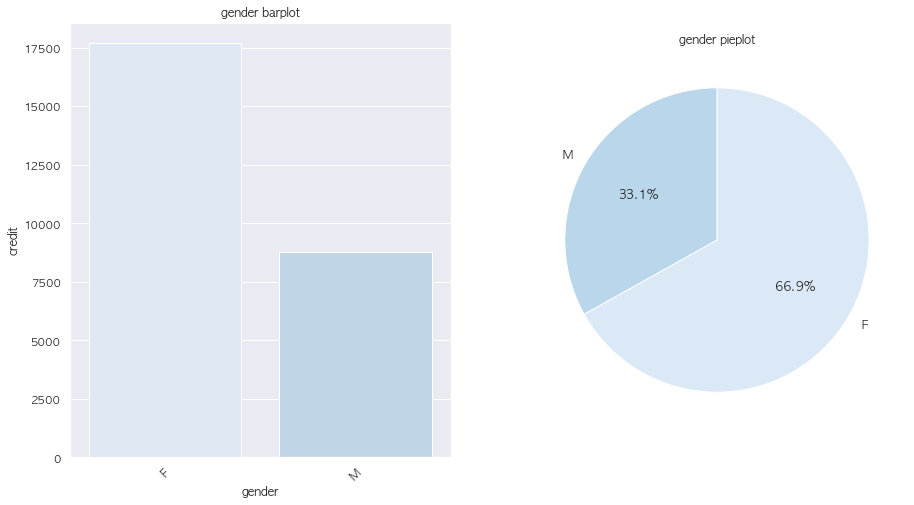

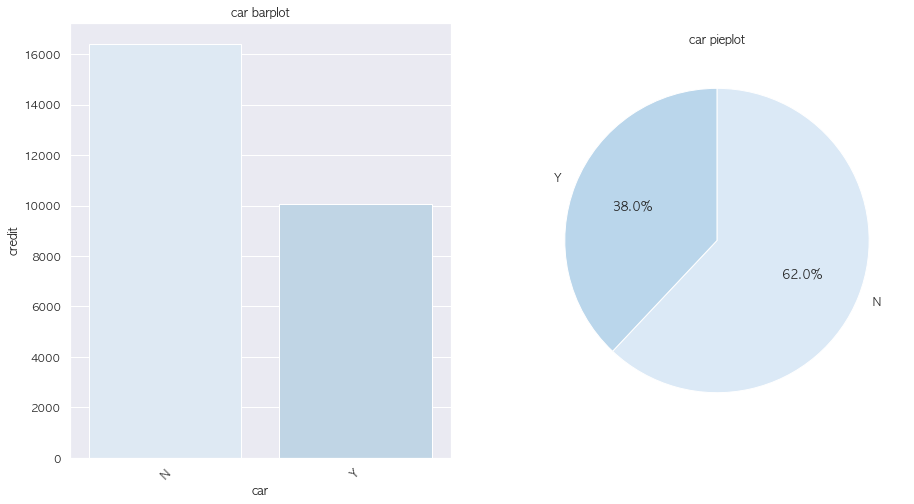

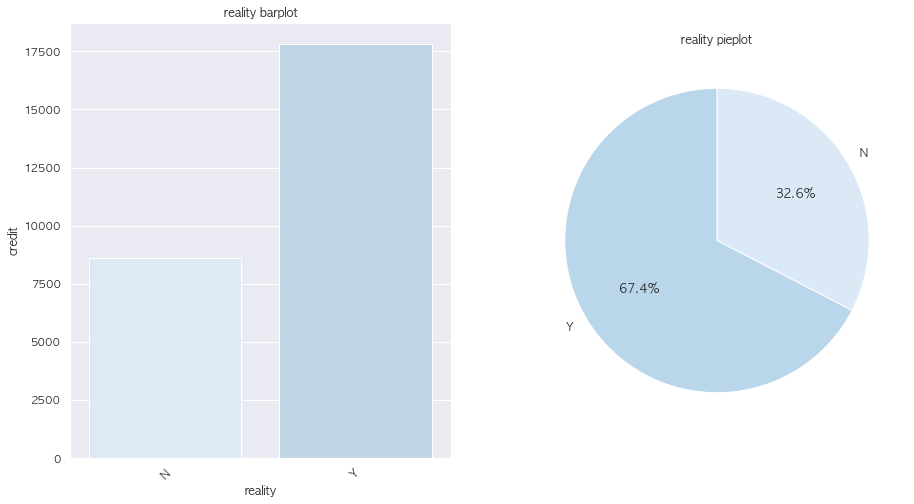

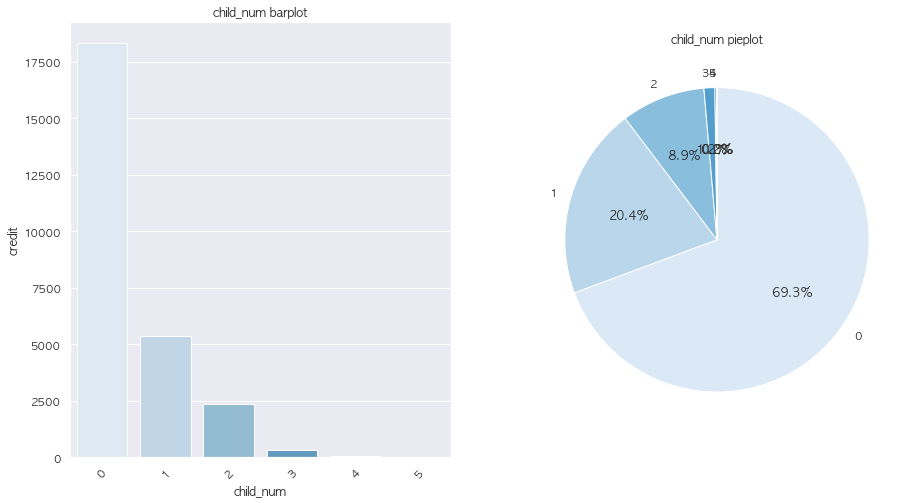

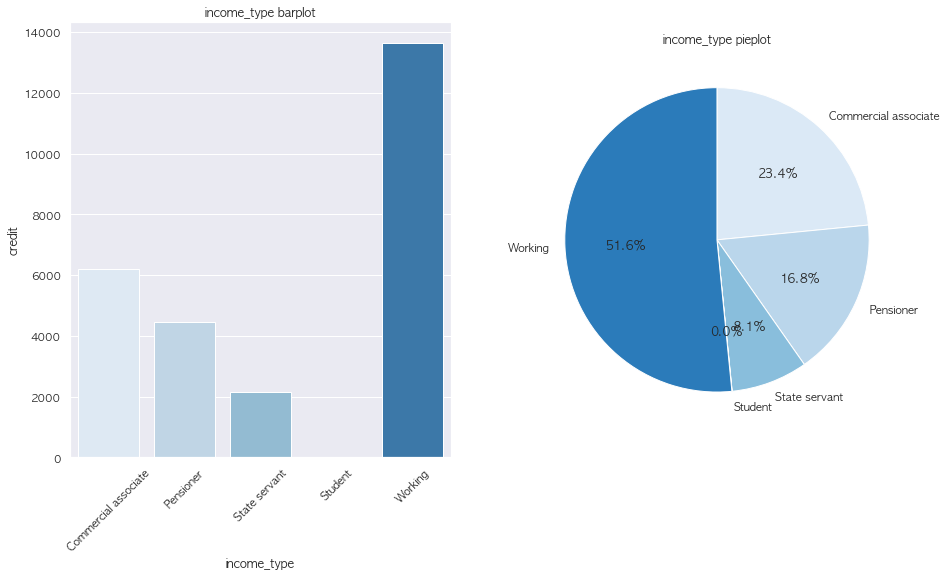

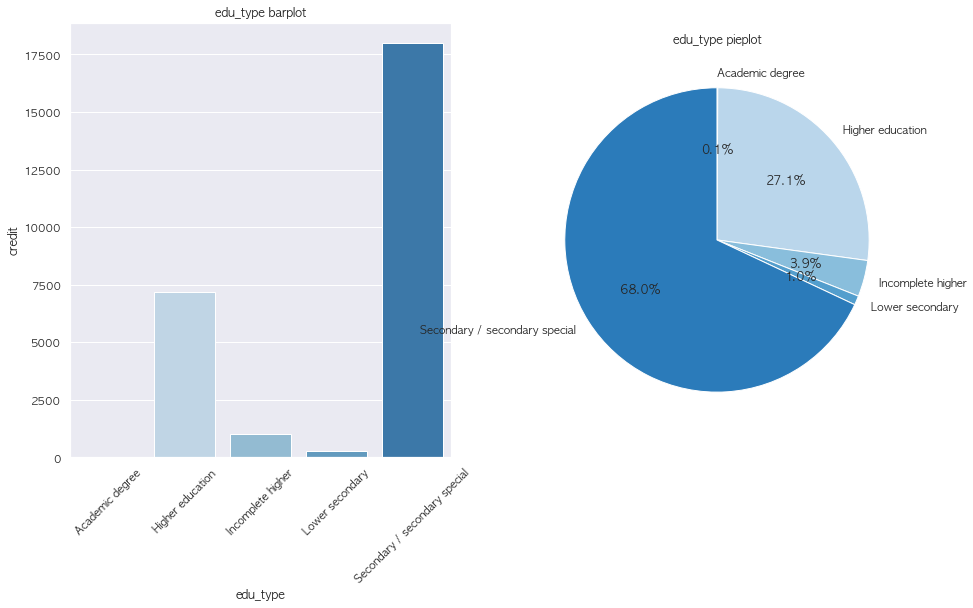

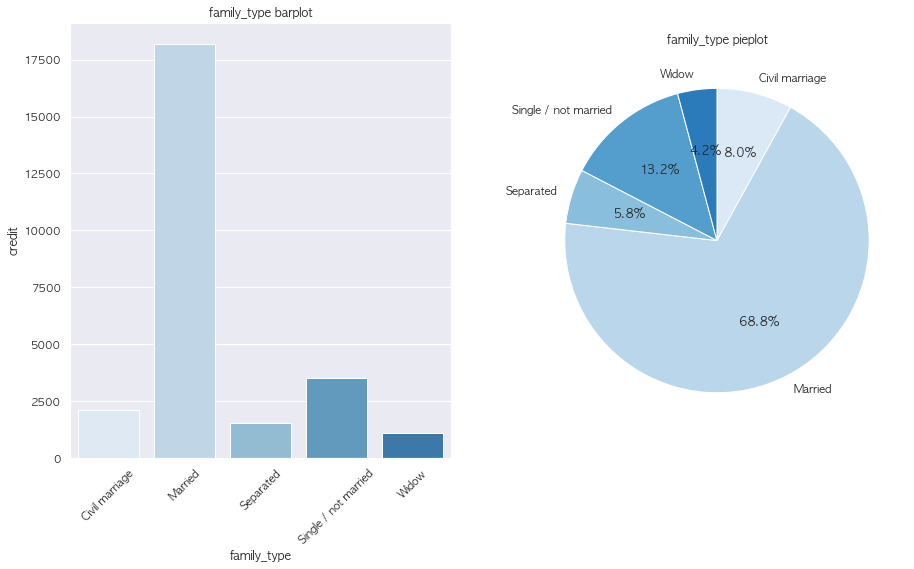

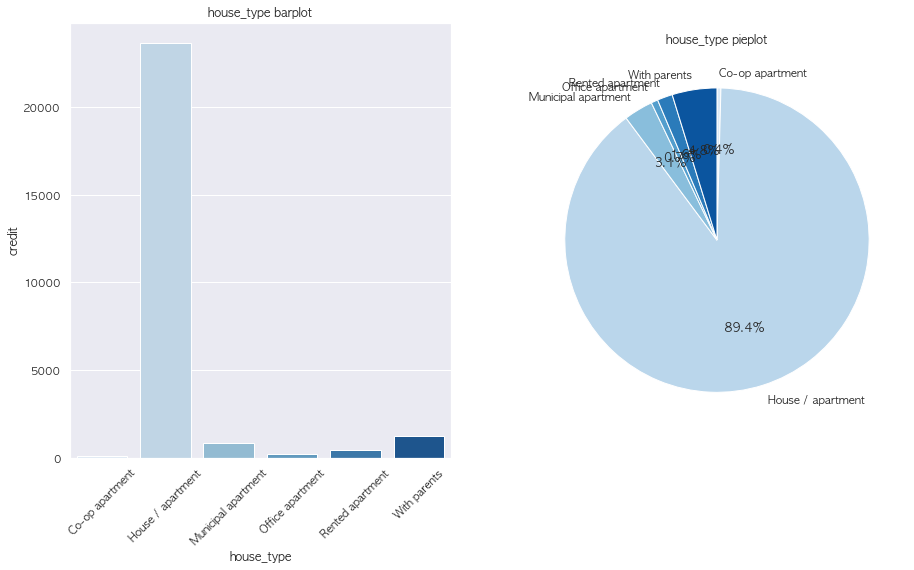

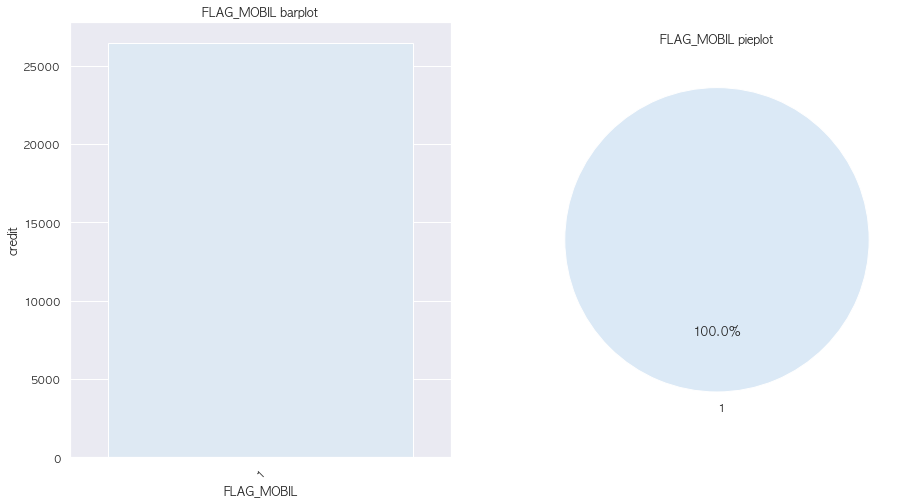

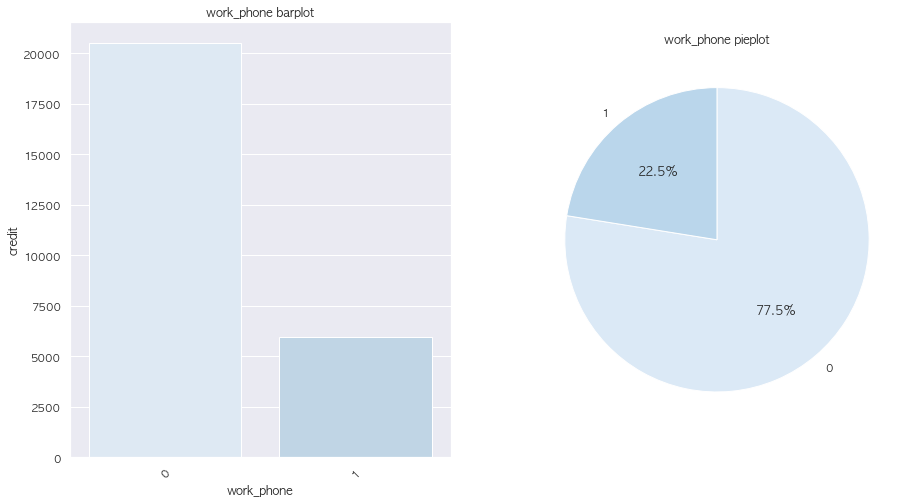

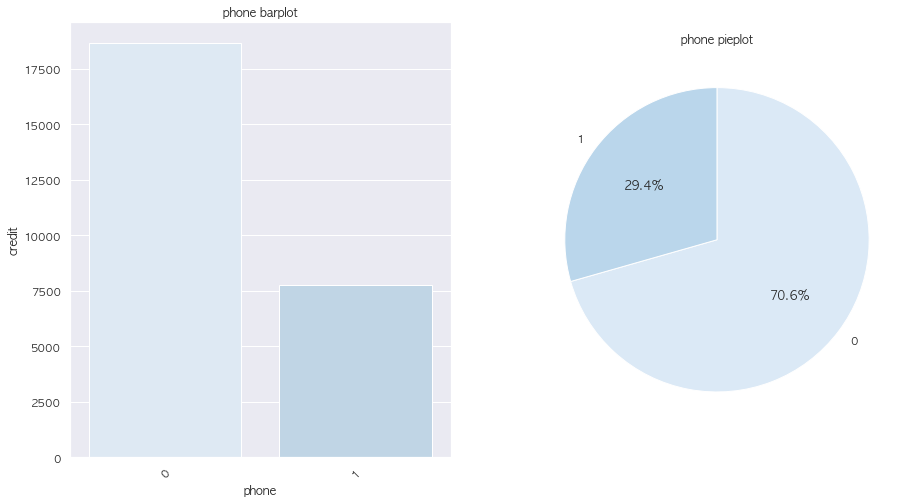

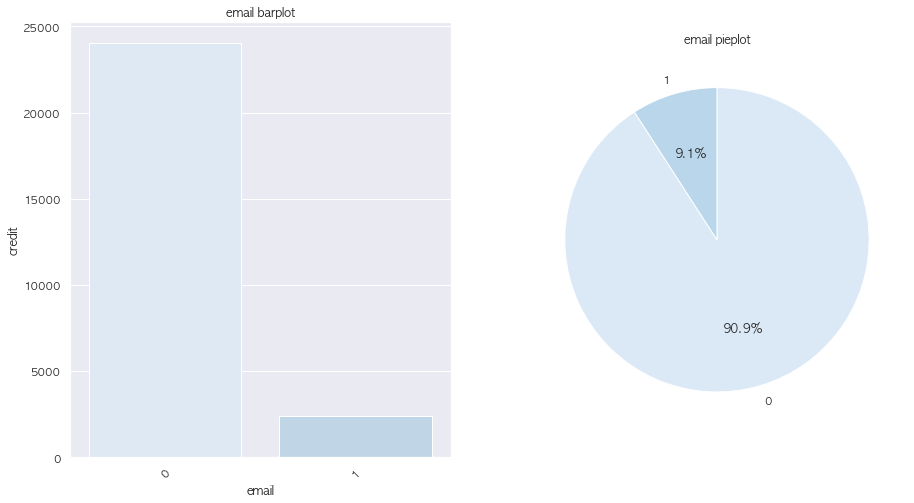

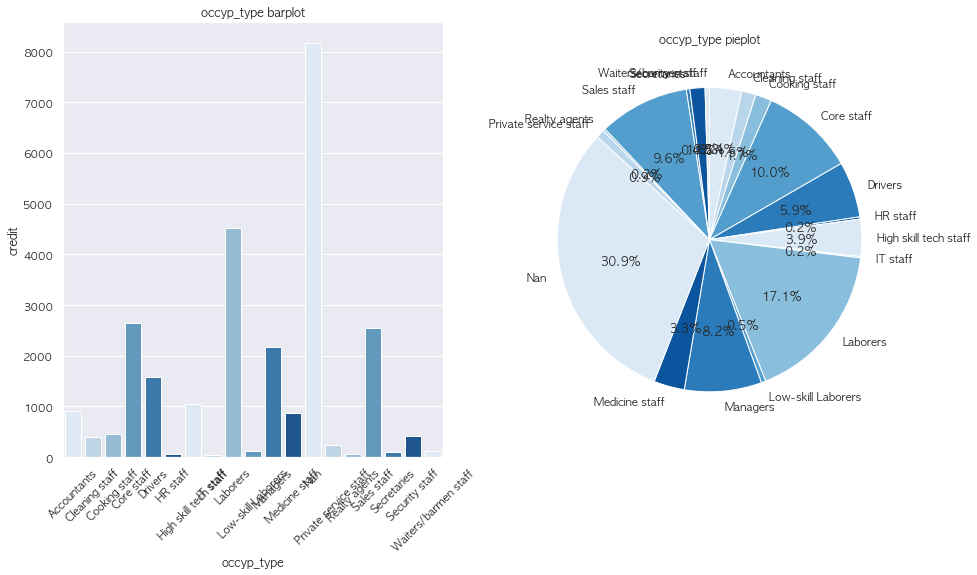

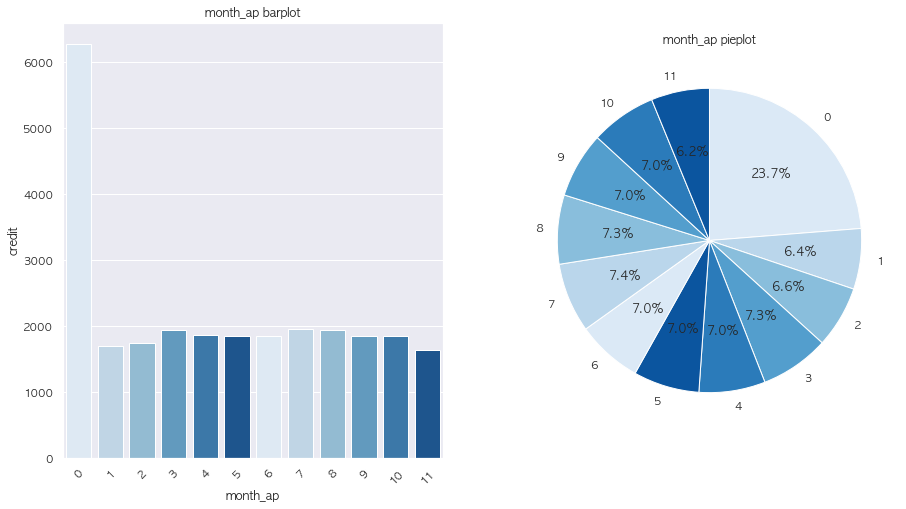

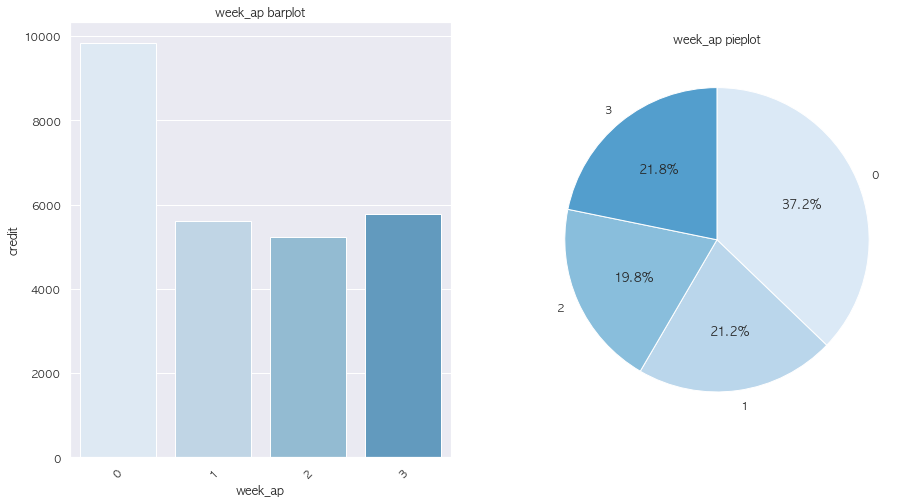

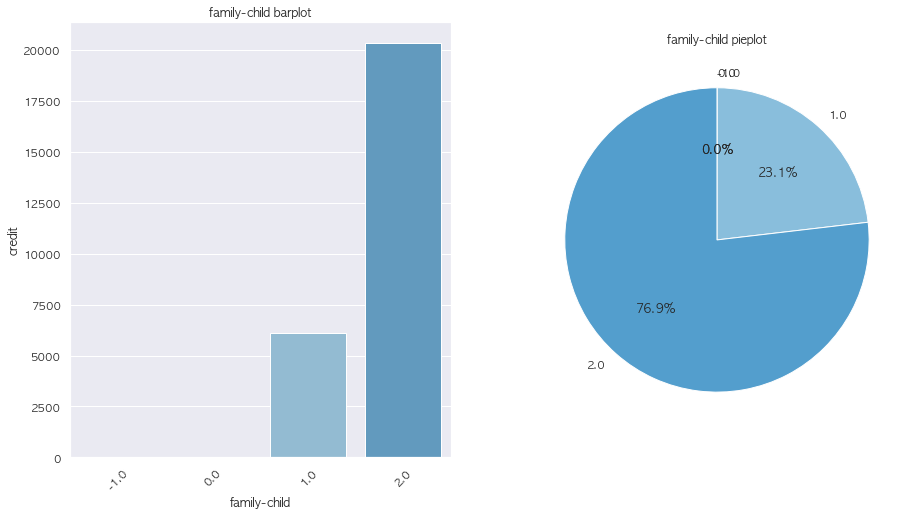

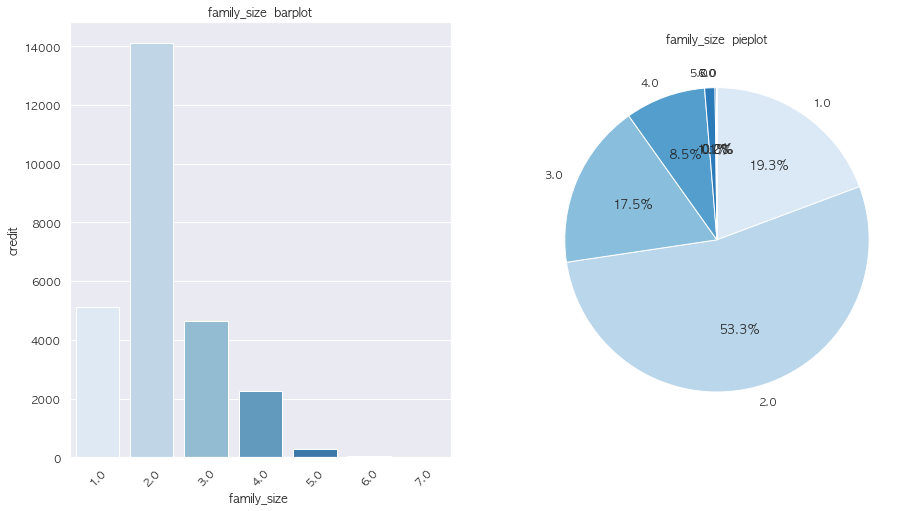

In [13]:
str_EDA(data)

In [14]:
def int_EDA(data):
  for i in data.columns:
    if data[i].dtypes != 'object':
      group_data = data.groupby([i],as_index=False).count()
      
      plt.figure(figsize=(15,8))
      plt.subplot(1,2,1)
      sns.distplot(data,x=data[i],bins=20)
      plt.title('%s histogram'%i)

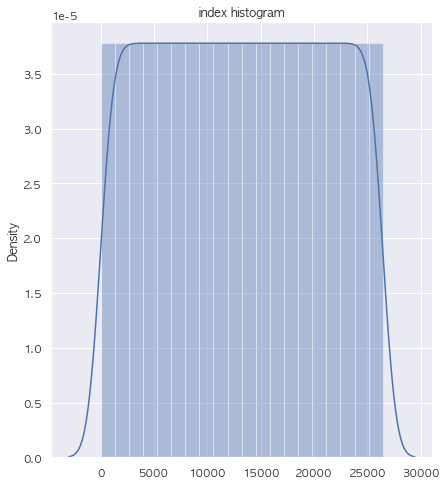

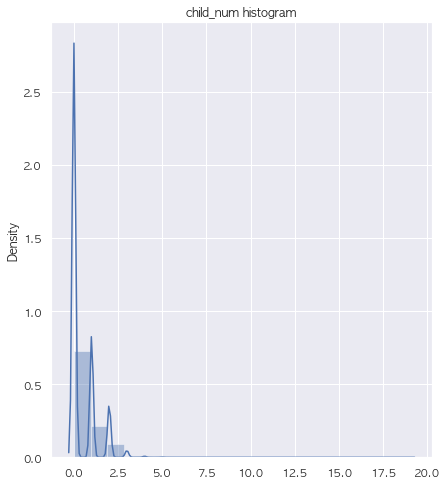

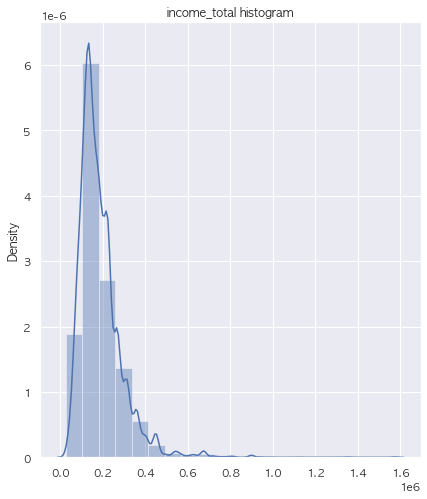

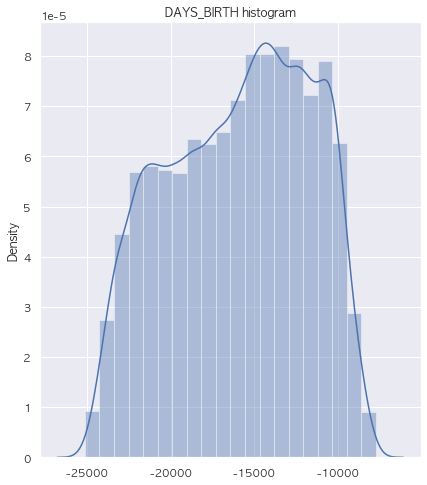

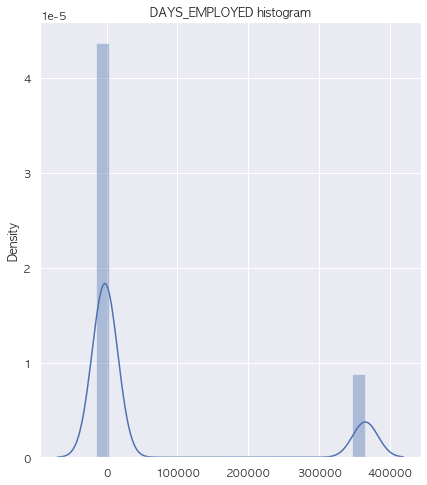

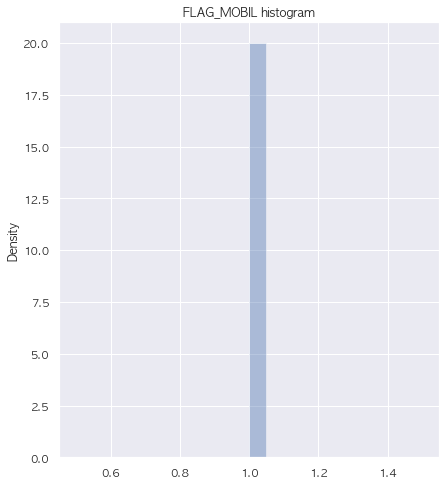

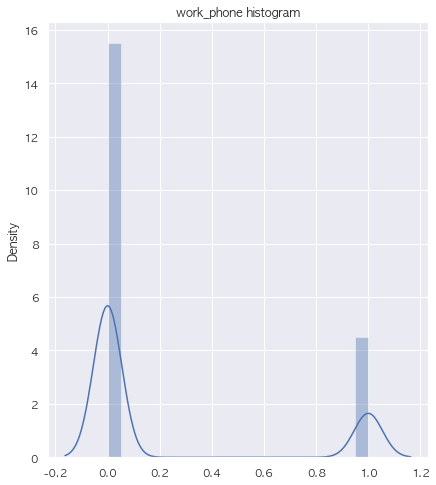

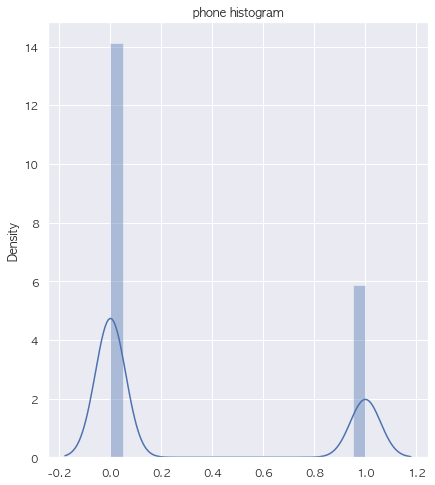

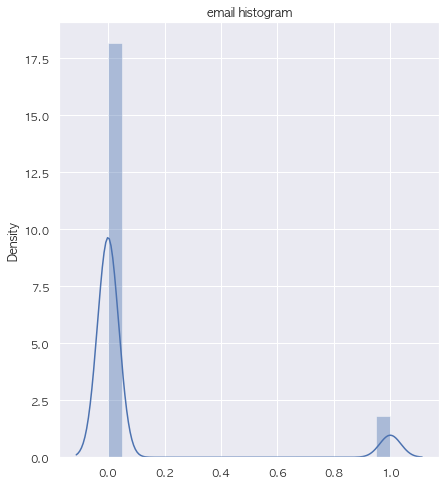

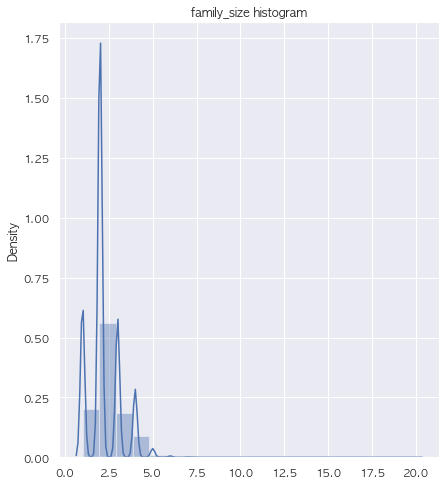

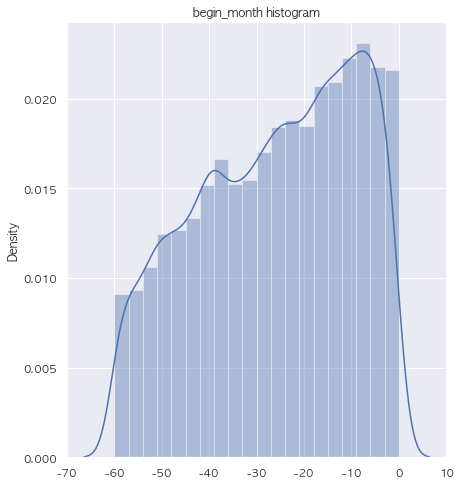

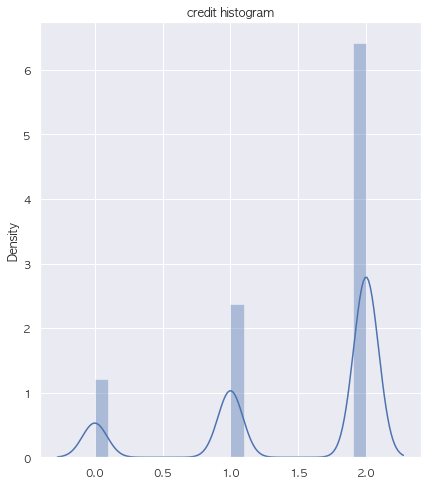

In [15]:
int_EDA(train)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           26451 non-null  int64  
 1   gender          26451 non-null  object 
 2   car             26451 non-null  object 
 3   reality         26451 non-null  object 
 4   child_num       26451 non-null  object 
 5   income_total    26451 non-null  float64
 6   income_type     26451 non-null  object 
 7   edu_type        26451 non-null  object 
 8   family_type     26451 non-null  object 
 9   house_type      26451 non-null  object 
 10  DAYS_BIRTH      26451 non-null  int64  
 11  DAYS_EMPLOYED   26451 non-null  int64  
 12  FLAG_MOBIL      26451 non-null  object 
 13  work_phone      26451 non-null  object 
 14  phone           26451 non-null  object 
 15  email           26451 non-null  object 
 16  occyp_type      26451 non-null  object 
 17  family_size     26451 non-null 

## 데이터 변수 선택

### 범주형 변수 선택

In [17]:
def list_sep (data):
  cat_list = []
  int_list = []
  for i in data.columns:
    if data[i].dtypes == 'object':
      cat_list.append(i)
    else :
      int_list.append(i)

  return int_list, cat_list

In [18]:
int_list, cat_list = list_sep(data)
print('int : ',int_list)
print('cat : ',cat_list)

int :  ['index', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month', 'credit', 'new_age', 'year_os', 'month_os', 'bef_hire', 'RATIO_EMPLOYED', 'aver_dep', 'year_income']
cat :  ['gender', 'car', 'reality', 'child_num', 'income_type', 'edu_type', 'family_type', 'house_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type', 'month_ap', 'week_ap', 'family-child', 'family_size ']


In [19]:
from scipy.stats import chi2_contingency

def cat_selection(data):
  #H0 : 독립변수의 범주형 변수(i)에 따른 종속변수 (credit)의 비율은 차이가 있다
  #H1 : 차이가 없다

  h0,h1,chi,c_list = [],[],[],[]

  for i in cat_list:
    chi_list = []
    cross_df = pd.crosstab(data[i],data['credit'],margins=False)
    result = chi2_contingency(observed=cross_df, correction=False)

    c_list.append(i)
    chi_list.append(result[0])
    chi_list.append(result[1])
    chi_list.append(result[2])
    chi.append(chi_list)

  chi_df = pd.DataFrame(columns=['chi_2','p-value','df'],data = chi)
  chi_df.index = c_list
  
  chi_df1 = chi_df[chi_df['p-value']<0.05]
  chi_df2= chi_df1[chi_df1['chi_2']>10]

  return chi_df, chi_df2

In [20]:
chi_df, chi_df_cat = cat_selection(data)

In [21]:
chi_df

,chi_2,p-value,df
gender,0.742683,6.898085e-01,2
car,9.366187,9.250354e-03,2
reality,11.230277,3.642304e-03,2
child_num,19.978358,2.945805e-02,10
income_type,23.800389,2.475172e-03,8
edu_type,8.886748,3.519398e-01,8
family_type,46.383397,2.009568e-07,8
house_type,37.725432,4.236293e-05,10
FLAG_MOBIL,0.000000,1.000000e+00,0
work_phone,0.385865,8.245374e-01,2


In [22]:
chi_df_cat

,chi_2,p-value,df
reality,11.230277,3.642304e-03,2
child_num,19.978358,2.945805e-02,10
income_type,23.800389,2.475172e-03,8
family_type,46.383397,2.009568e-07,8
house_type,37.725432,4.236293e-05,10
occyp_type,90.398801,1.422022e-06,36
month_ap,66.017750,2.756842e-06,22
family-child,25.970734,2.254547e-04,6
family_size,39.212899,9.706224e-05,12


In [23]:
list(chi_df_cat.index)

['reality',
 'child_num',
 'income_type',
 'family_type',
 'house_type',
 'occyp_type',
 'month_ap',
 'family-child',
 'family_size ']

### 수치형 변수 선택

In [24]:
int_list

['index',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'family_size',
 'begin_month',
 'credit',
 'new_age',
 'year_os',
 'month_os',
 'bef_hire',
 'RATIO_EMPLOYED',
 'aver_dep',
 'year_income']

In [25]:
import statsmodels.api as sm

def logis_glm_one(data):
  data['credit'] = data['credit'].astype('int')
  output = data['credit']
  for i in int_list:
    feature = data[i]
    model = sm.formula.glm('output ~ feature',data,family = sm.families.Binomial()).fit()
    print('logistic %s'%i)
    print(model.summary())
    print(model.params)
    print(np.exp(model.params))
    print(np.log(model.params))
    print()

In [26]:
logis_glm_one(data)

logistic index
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 output   No. Observations:                26451
Model:                            GLM   Df Residuals:                    26449
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Wed, 25 Jan 2023   Deviance:                   1.5665e+06
Time:                        20:38:26   Pearson chi2:                 9.09e+19
No. Iterations:                     3   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.383e+15   8.25e+05   2.

In [27]:
def logis_glm(data):
  output = data['credit'].astype('int')
  formula = 'output ~ income_total + DAYS_BIRTH + DAYS_EMPLOYED + family_size + begin_month + new_age + year_os + month_os + bef_hire + RATIO_EMPLOYED +aver_dep + year_income'
  model = sm.formula.glm(formula,data,family = sm.families.Binomial()).fit()
  return model.summary(), np.exp(model.params)

In [28]:
logis_glm(data)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                  Generalized Linear Model Regression Results                  
 Dep. Variable:                 output   No. Observations:                26451
 Model:                            GLM   Df Residuals:                    26439
 Model Family:                Binomial   Df Model:                           11
 Link Function:                  Logit   Scale:                          1.0000
 Method:                          IRLS   Log-Likelihood:                   -inf
 Date:                Wed, 25 Jan 2023   Deviance:                   1.5665e+06
 Time:                        20:38:53   Pearson chi2:                 9.09e+19
 No. Iterations:                     5   Pseudo R-squ. (CS):                nan
 Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
 -----------------------------------------------------------------

In [29]:
dt = data[data['credit'] != 2.0]
logis_glm(dt)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                  Generalized Linear Model Regression Results                  
 Dep. Variable:                 output   No. Observations:                 9489
 Model:                            GLM   Df Residuals:                     9477
 Model Family:                Binomial   Df Model:                           11
 Link Function:                  Logit   Scale:                          1.0000
 Method:                          IRLS   Log-Likelihood:                -6033.6
 Date:                Wed, 25 Jan 2023   Deviance:                       12067.
 Time:                        20:39:03   Pearson chi2:                 9.48e+03
 No. Iterations:                     4   Pseudo R-squ. (CS):           0.009716
 Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
 -----------------------------------------------------------------

In [ ]:
dt = data[data['credit'] != 1.0]
logis_glm(dt)

/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


(<class 'statsmodels.iolib.summary.Summary'>
 """
                  Generalized Linear Model Regression Results                  
 Dep. Variable:                 output   No. Observations:                20184
 Model:                            GLM   Df Residuals:                    20172
 Model Family:                Binomial   Df Model:                           11
 Link Function:                  logit   Scale:                          1.0000
 Method:                          IRLS   Log-Likelihood:                   -inf
 Date:                Wed, 25 Jan 2023   Deviance:                   1.5665e+06
 Time:                        08:05:47   Pearson chi2:                 9.09e+19
 No. Iterations:                     4                                         
 Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
 -----------------------------------------------------------------

In [30]:
dt = data[data['credit'] != 0.0]
logis_glm(dt)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                  Generalized Linear Model Regression Results                  
 Dep. Variable:                 output   No. Observations:                23229
 Model:                            GLM   Df Residuals:                    23217
 Model Family:                Binomial   Df Model:                           11
 Link Function:                  Logit   Scale:                          1.0000
 Method:                          IRLS   Log-Likelihood:                   -inf
 Date:                Wed, 25 Jan 2023   Deviance:                   1.2698e+06
 Time:                        20:39:05   Pearson chi2:                 7.64e+19
 No. Iterations:                     4   Pseudo R-squ. (CS):                nan
 Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
 -----------------------------------------------------------------

### VIF (다중공선성)

In [31]:
data.tail()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,new_age,year_os,month_os,month_ap,week_ap,bef_hire,RATIO_EMPLOYED,aver_dep,year_income,family-child,family_size
26446,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,12079,1984,1,0,0,0,Core staff,4.0,2.0,1,33,5,66,6,3,10095,0.164252,56250.0,45000.0,2.0,4.0
26447,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,15291,2475,1,0,0,0,Nan,2.0,47.0,2,42,6,82,10,1,12816,0.161860,90000.0,30000.0,1.0,2.0
26448,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,10082,2015,1,0,0,0,Core staff,2.0,25.0,2,28,5,67,7,3,8067,0.199861,146250.0,58500.0,2.0,2.0
26449,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,10145,107,1,0,0,0,Laborers,1.0,59.0,2,28,0,3,3,3,10038,0.010547,171000.0,0.0,1.0,1.0
26450,26456,F,N,N,0,81000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,19569,1013,1,0,0,0,Security staff,2.0,9.0,2,54,2,33,9,0,18556,0.051766,40500.0,40500.0,2.0,2.0


### 총합 변수 선택

In [32]:
cat_selec, int_selec = list(chi_df_cat.index),['income_total','DAYS_EMPLOYED','begin_month','new_age','aver_dep','year_income']
cat_int_selec = cat_selec + int_selec
cat_int_selec

['reality',
 'child_num',
 'income_type',
 'family_type',
 'house_type',
 'occyp_type',
 'month_ap',
 'family-child',
 'family_size ',
 'income_total',
 'DAYS_EMPLOYED',
 'begin_month',
 'new_age',
 'aver_dep',
 'year_income']

In [33]:
for i in cat_selec:
  print(i)

reality
child_num
income_type
family_type
house_type
occyp_type
month_ap
family-child
family_size 


In [34]:
for i in cat_selec:
  data[i] = data[i].astype('object')

## 최종 데이터 셋 구성
+ 변수 선택을 통해 적합한 칼럼만 분석에 사용

In [36]:
df_train = data[cat_int_selec]
df_train

,reality,child_num,income_type,family_type,house_type,occyp_type,month_ap,family-child,family_size,income_total,DAYS_EMPLOYED,begin_month,new_age,aver_dep,year_income
0,N,0,Commercial associate,Married,Municipal apartment,Nan,0,2.0,2.0,202500.0,4709,6.0,38,101250.0,16875.0
1,Y,1,Commercial associate,Civil marriage,House / apartment,Laborers,3,2.0,3.0,247500.0,1540,5.0,31,82500.0,61875.0
2,Y,0,Working,Married,House / apartment,Managers,3,2.0,2.0,450000.0,4434,22.0,52,225000.0,37500.0
3,Y,0,Commercial associate,Married,House / apartment,Sales staff,9,2.0,2.0,202500.0,2092,37.0,41,101250.0,40500.0
4,Y,0,State servant,Married,House / apartment,Managers,10,2.0,2.0,157500.0,2105,26.0,41,78750.0,31500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,N,2,State servant,Married,House / apartment,Core staff,6,2.0,4.0,225000.0,1984,2.0,33,56250.0,45000.0
26447,Y,1,Working,Separated,House / apartment,Nan,10,1.0,2.0,180000.0,2475,47.0,42,90000.0,30000.0
26448,N,0,Working,Civil marriage,With parents,Core staff,7,2.0,2.0,292500.0,2015,25.0,28,146250.0,58500.0
26449,Y,0,Working,Single / not married,House / apartment,Laborers,3,1.0,1.0,171000.0,107,59.0,28,171000.0,0.0


In [ ]:
#df_train.to_csv('/content/drive/MyDrive/신용카드/df_train.csv',index=False)

## 모델링 전처리

### train test split

In [37]:
X = df_train
y = data['credit']

In [ ]:
#train = df_train.copy()
#X = train.drop(['credit'],axis=1)
#y = df_train['credit']

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2, random_state = 2023, shuffle=False)
print('X_train : ', X_train.shape)
print('y_train : ', y_train.shape)
print('X_valid : ', X_valid.shape)
print('y_valid : ', y_valid.shape)

X_train :  (21160, 15)
y_train :  (21160,)
X_valid :  (5291, 15)
y_valid :  (5291,)


### 인코딩 : OrdinalEncoder

In [39]:
train_int, train_cat = list_sep(X_train)
print('train_cat : ',train_cat)
print('train_int : ',train_int)

train_cat :  ['reality', 'child_num', 'income_type', 'family_type', 'house_type', 'occyp_type', 'month_ap', 'family-child', 'family_size ']
train_int :  ['income_total', 'DAYS_EMPLOYED', 'begin_month', 'new_age', 'aver_dep', 'year_income']


In [40]:
from sklearn.preprocessing import OrdinalEncoder

Encoder = OrdinalEncoder()
X_train_encoder = Encoder.fit_transform(X_train[train_cat],y_train)

print('X_train_encoder.shape :',X_train_encoder.shape)
print('len(train_cat) : ', len(train_cat))

X_train_encoder.shape : (21160, 9)
len(train_cat) :  9


### 스케일링 : StandardScaler
+ 분류에 유용

In [41]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
X_train_Scaled = X_train[train_int] = Scaler.fit_transform(X_train[train_int],y_train)
print('X_train_Scaled.shape : ',X_train_Scaled.shape)
print('len(train_int) : ',len(train_int))

X_train_Scaled.shape :  (21160, 6)
len(train_int) :  6


### 데이터 프레임 생성

In [42]:
X_train_encoder = pd.DataFrame(X_train_encoder)
X_train_encoder.columns = train_cat

X_train_Scaled = pd.DataFrame(X_train_Scaled)
X_train_Scaled.columns = train_int

pre_X_train = pd.concat([X_train_encoder,X_train_Scaled],axis=1)
pre_X_train

,reality,child_num,income_type,family_type,house_type,occyp_type,month_ap,family-child,family_size,income_total,DAYS_EMPLOYED,begin_month,new_age,aver_dep,year_income
0,0.0,0.0,0.0,1.0,2.0,12.0,0.0,3.0,1.0,0.155552,1.056337,-1.216428,-0.490897,0.006481,-0.413602
1,1.0,1.0,0.0,0.0,1.0,8.0,3.0,3.0,2.0,0.603183,-0.278348,-1.276886,-1.097830,-0.251629,0.307754
2,1.0,0.0,4.0,1.0,1.0,10.0,3.0,3.0,1.0,2.617524,0.940515,-0.249098,0.722967,1.710003,-0.082981
3,1.0,0.0,0.0,1.0,1.0,15.0,9.0,3.0,1.0,0.155552,-0.045863,0.657773,-0.230783,0.006481,-0.034890
4,1.0,0.0,2.0,1.0,1.0,10.0,10.0,3.0,1.0,-0.292080,-0.040388,-0.007266,-0.230783,-0.303250,-0.179162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21155,1.0,1.0,4.0,1.0,1.0,10.0,0.0,3.0,2.0,1.274630,-0.314148,-0.853679,-1.011125,0.058103,0.999054
21156,1.0,0.0,1.0,4.0,1.0,12.0,0.0,2.0,0.0,-0.829237,-0.926949,-0.430473,1.850127,0.037454,-0.684111
21157,1.0,0.0,1.0,1.0,1.0,12.0,0.0,3.0,1.0,0.155552,-0.926949,0.718231,1.763423,0.006481,-0.684111
21158,1.0,2.0,4.0,1.0,1.0,8.0,0.0,3.0,3.0,0.379367,0.139030,0.053192,-1.184534,-0.612982,-0.082981


In [ ]:
#pre_X = pre_X_train.copy()
#pre_X['y_train'] = y_train
#pre_X.to_csv('/content/drive/MyDrive/신용카드/Xy_train_nonsmote.csv',index=False)
#pre_X

### 오버 샘플링 : SMOTE

In [43]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=23)
pre_X_train_over, y_train_over = smote.fit_resample(pre_X_train, y_train)

print('X_train : ', pre_X_train.shape)
print('y_train : ', y_train.shape)
print('X_train_over : ', pre_X_train_over.shape)
print('y_train_over : ', y_train_over.shape)

X_train :  (21160, 15)
y_train :  (21160,)
X_train_over :  (40851, 15)
y_train_over :  (40851,)


In [44]:
Xy_train = pre_X_train_over.copy()
Xy_train['credit'] = y_train_over
Xy_train

,reality,child_num,income_type,family_type,house_type,occyp_type,month_ap,family-child,family_size,income_total,DAYS_EMPLOYED,begin_month,new_age,aver_dep,year_income,credit
0,0.000000,0.0,0.0,1.000000,2.0,12.0,0.000000,3.000000,1.000000,0.155552,1.056337,-1.216428,-0.490897,0.006481,-0.413602,1
1,1.000000,1.0,0.0,0.000000,1.0,8.0,3.000000,3.000000,2.000000,0.603183,-0.278348,-1.276886,-1.097830,-0.251629,0.307754,1
2,1.000000,0.0,4.0,1.000000,1.0,10.0,3.000000,3.000000,1.000000,2.617524,0.940515,-0.249098,0.722967,1.710003,-0.082981,2
3,1.000000,0.0,0.0,1.000000,1.0,15.0,9.000000,3.000000,1.000000,0.155552,-0.045863,0.657773,-0.230783,0.006481,-0.034890,0
4,1.000000,0.0,2.0,1.000000,1.0,10.0,10.000000,3.000000,1.000000,-0.292080,-0.040388,-0.007266,-0.230783,-0.303250,-0.179162,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40846,0.000000,1.0,0.0,0.000000,1.0,15.0,6.000000,3.000000,2.000000,-0.515895,-0.843978,-0.633944,-0.751011,-0.767847,-0.684111,1
40847,1.000000,0.0,0.0,2.931896,1.0,0.0,9.965948,2.034052,0.034052,0.178416,1.484805,-1.573000,-0.608209,1.368630,-0.465248,1
40848,0.000000,2.0,4.0,1.000000,1.0,8.0,5.000000,3.000000,3.000000,-0.264117,0.186000,1.768680,-1.027353,-0.835606,-0.295261,1
40849,0.306822,1.0,4.0,1.000000,1.0,3.0,8.693178,3.000000,2.000000,-0.894855,0.568645,0.080675,-1.117537,-0.942657,-0.505062,1


In [45]:
print(len(Xy_train[Xy_train['credit'] == 2.0]))
print(len(Xy_train[Xy_train['credit'] == 1.0]))
print(len(Xy_train[Xy_train['credit'] == 0.0]))

13617
13617
13617


In [46]:
def Xy_train_data(X_test):
  X_test_encoder = Encoder.transform(X_test[train_cat])
  X_test_Scaled = Scaler.transform(X_test[train_int])

  X_test_encoder = pd.DataFrame(X_test_encoder)
  X_test_encoder.columns = train_cat

  X_test_Scaled = pd.DataFrame(X_test_Scaled)
  X_test_Scaled.columns = train_int

  pre_X_test = pd.concat([X_test_encoder,X_test_Scaled],axis=1)
  return pre_X_test

### 최종 데이터 셋

In [47]:
Xy_train

,reality,child_num,income_type,family_type,house_type,occyp_type,month_ap,family-child,family_size,income_total,DAYS_EMPLOYED,begin_month,new_age,aver_dep,year_income,credit
0,0.000000,0.0,0.0,1.000000,2.0,12.0,0.000000,3.000000,1.000000,0.155552,1.056337,-1.216428,-0.490897,0.006481,-0.413602,1
1,1.000000,1.0,0.0,0.000000,1.0,8.0,3.000000,3.000000,2.000000,0.603183,-0.278348,-1.276886,-1.097830,-0.251629,0.307754,1
2,1.000000,0.0,4.0,1.000000,1.0,10.0,3.000000,3.000000,1.000000,2.617524,0.940515,-0.249098,0.722967,1.710003,-0.082981,2
3,1.000000,0.0,0.0,1.000000,1.0,15.0,9.000000,3.000000,1.000000,0.155552,-0.045863,0.657773,-0.230783,0.006481,-0.034890,0
4,1.000000,0.0,2.0,1.000000,1.0,10.0,10.000000,3.000000,1.000000,-0.292080,-0.040388,-0.007266,-0.230783,-0.303250,-0.179162,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40846,0.000000,1.0,0.0,0.000000,1.0,15.0,6.000000,3.000000,2.000000,-0.515895,-0.843978,-0.633944,-0.751011,-0.767847,-0.684111,1
40847,1.000000,0.0,0.0,2.931896,1.0,0.0,9.965948,2.034052,0.034052,0.178416,1.484805,-1.573000,-0.608209,1.368630,-0.465248,1
40848,0.000000,2.0,4.0,1.000000,1.0,8.0,5.000000,3.000000,3.000000,-0.264117,0.186000,1.768680,-1.027353,-0.835606,-0.295261,1
40849,0.306822,1.0,4.0,1.000000,1.0,3.0,8.693178,3.000000,2.000000,-0.894855,0.568645,0.080675,-1.117537,-0.942657,-0.505062,1


In [ ]:
#Xy_train.to_csv('/content/drive/MyDrive/신용카드/Xy_train.csv',index=False)

In [48]:
pre_X_valid = Xy_train_data(X_valid)
pre_X_valid

,reality,child_num,income_type,family_type,house_type,occyp_type,month_ap,family-child,family_size,income_total,DAYS_EMPLOYED,begin_month,new_age,aver_dep,year_income
0,1.0,0.0,1.0,4.0,1.0,12.0,0.0,2.0,0.0,-0.292080,-0.926949,0.113650,2.023536,0.780809,-0.684111
1,0.0,0.0,4.0,1.0,5.0,12.0,4.0,3.0,1.0,-0.515895,-0.560953,-1.579176,-0.837716,-0.458116,0.397924
2,1.0,1.0,4.0,1.0,1.0,12.0,1.0,3.0,2.0,0.155552,0.453644,1.141438,0.202740,-0.458116,-0.278356
3,0.0,0.0,4.0,1.0,1.0,12.0,5.0,3.0,1.0,-0.829237,1.869614,-1.276886,0.029330,-0.674928,-0.591938
4,1.0,0.0,2.0,1.0,1.0,12.0,7.0,3.0,1.0,-1.187342,3.873537,1.080980,0.896377,-0.922713,-0.649214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,0.0,2.0,2.0,1.0,1.0,3.0,6.0,3.0,3.0,0.379367,-0.091349,-1.458260,-0.924420,-0.612982,0.037245
5287,1.0,1.0,4.0,2.0,1.0,12.0,10.0,2.0,1.0,-0.068264,0.115445,1.262354,-0.144079,-0.148385,-0.203207
5288,0.0,0.0,4.0,0.0,5.0,3.0,7.0,3.0,1.0,1.050814,-0.078293,-0.067724,-1.357943,0.625943,0.253652
5289,1.0,0.0,4.0,3.0,1.0,8.0,3.0,2.0,0.0,-0.157790,-0.881884,1.987852,-1.357943,0.966648,-0.684111


In [49]:
len(y_valid)

5291

In [50]:
y_valid = y_valid.reset_index(drop=True)
#pre_valid = pre_X_valid.copy()
#pre_valid['y_train'] = y_valid.copy()
#pre_valid.to_csv('/content/drive/MyDrive/신용카드/Xy_valid.csv', index=False)
#pre_valid

In [51]:
test = pd.read_csv('/Users/choejeehyuk/분석에 필요한 데이터/신용커드 예측 경진대회/test.csv')
test = make_derivation(test)
test = change_type(test)
X_test = test[cat_int_selec]
X_test
#Xy_train_data(test)

,reality,child_num,income_type,family_type,house_type,occyp_type,month_ap,family-child,family_size,income_total,DAYS_EMPLOYED,begin_month,new_age,aver_dep,year_income
0,N,0,Pensioner,Civil marriage,House / apartment,0,0,2.0,2.0,112500.0,0,60.0,60,56250.0,0.0
1,Y,0,State servant,Married,House / apartment,Core staff,1,2.0,2.0,135000.0,8671,36.0,52,67500.0,5869.0
2,Y,0,Working,Married,House / apartment,Laborers,7,2.0,2.0,69372.0,217,40.0,43,34686.0,0.0
3,N,0,Commercial associate,Married,House / apartment,Drivers,0,2.0,2.0,112500.0,2531,41.0,53,56250.0,18750.0
4,Y,0,State servant,Married,House / apartment,Managers,0,2.0,2.0,225000.0,9385,8.0,49,112500.0,9000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Y,0,Working,Married,House / apartment,Accountants,1,2.0,2.0,202500.0,5434,19.0,51,101250.0,14464.0
9996,Y,0,Working,Civil marriage,House / apartment,Laborers,7,2.0,2.0,202500.0,1315,34.0,30,101250.0,67500.0
9997,Y,0,Working,Married,House / apartment,Medicine staff,11,2.0,2.0,292500.0,14018,55.0,57,146250.0,7697.0
9998,N,0,Commercial associate,Married,House / apartment,0,0,2.0,2.0,180000.0,1085,33.0,45,90000.0,90000.0


In [52]:
for i in range(len(X_test)):
  if X_test['occyp_type'][i] == 0:
     X_test['occyp_type'][i] = 'Nan'

KeyboardInterrupt: 

In [ ]:
pre_X_test = Xy_train_data(X_test)
#pre_X_test.to_csv('/content/drive/MyDrive/신용카드/X_test.csv',index=False)

## 모델링